In [1]:
import numpy as np
import matplotlib.pyplot as plt 

fs = 200000

#Import Data
fm_real = np.genfromtxt('fm_signal_real_fs_200kHz.dat')
print(abs(fm_real).max())

fm_imag = np.genfromtxt('fm_signal_imag_fs_200kHz.dat')
print(abs(fm_imag).max())

fm_complex = fm_real + 1j * fm_imag

67.0
67.0


In [3]:
#Demodulation

signal = np.zeros(len(fm_complex))
last_in = 0 + 1j * 0
for i in range(len(fm_complex)-1):
    signal[i] = np.imag(fm_complex[i]*last_in.conjugate())
    last_in = fm_complex[i]



np.savetxt("/Users/dave/Documents/FM-Demodulator/Python/demod.txt", X = signal, fmt= "%d")


In [4]:
# Offset beseitigen mit Mittelwertfilter

WINDOW_SIZE = 128


shift_register = [0.0] * WINDOW_SIZE

output_samples = []
for x in range (len(signal)):

  # Lese das aktuelle Eingangssample 
  input_sample = signal[x]
  # Berechne den Mittelwert aus dem Schieberegister
  mean = np.int16(sum(shift_register) / len(shift_register))

  # Füge das aktuelle Sample am Ende des Schieberegisters hinzu und entferne das älteste Sample
  shift_register.append(input_sample)
  shift_register.pop(0)

  # Ziehe den Mittelwert von dem aktuellen Sample ab 
  output_sample = input_sample - mean
  output_samples.append(output_sample)

print(np.max(np.abs(output_samples)))
np.savetxt('/Users/dave/Documents/FM-Demodulator/Python/demod_avg.txt', X = output_samples, fmt = '%d')




5692.0


Text(0.5, 1.0, 'Impulsantwort')

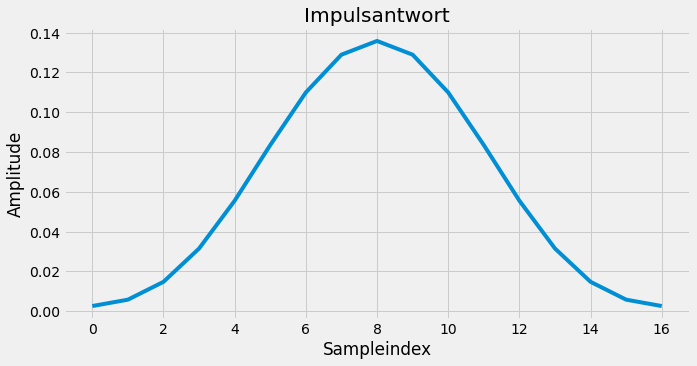

In [5]:
from scipy.signal import firwin
from scipy import signal


#Berechne Filterkoeffizienten
fs = 200e3
N_taps = 17
Cutoff = 10e3

b = firwin(N_taps, Cutoff, fs=fs)

np.savetxt('/Users/dave/Documents/FM-Demodulator/Python/FIR17_10kHz_0.16.txt', np.int16(b*2**16), fmt="%d")

#Plot Taps
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,5))
plt.plot(b)
plt.ylabel('Amplitude')
plt.xlabel('Sampleindex')
plt.title('Impulsantwort')

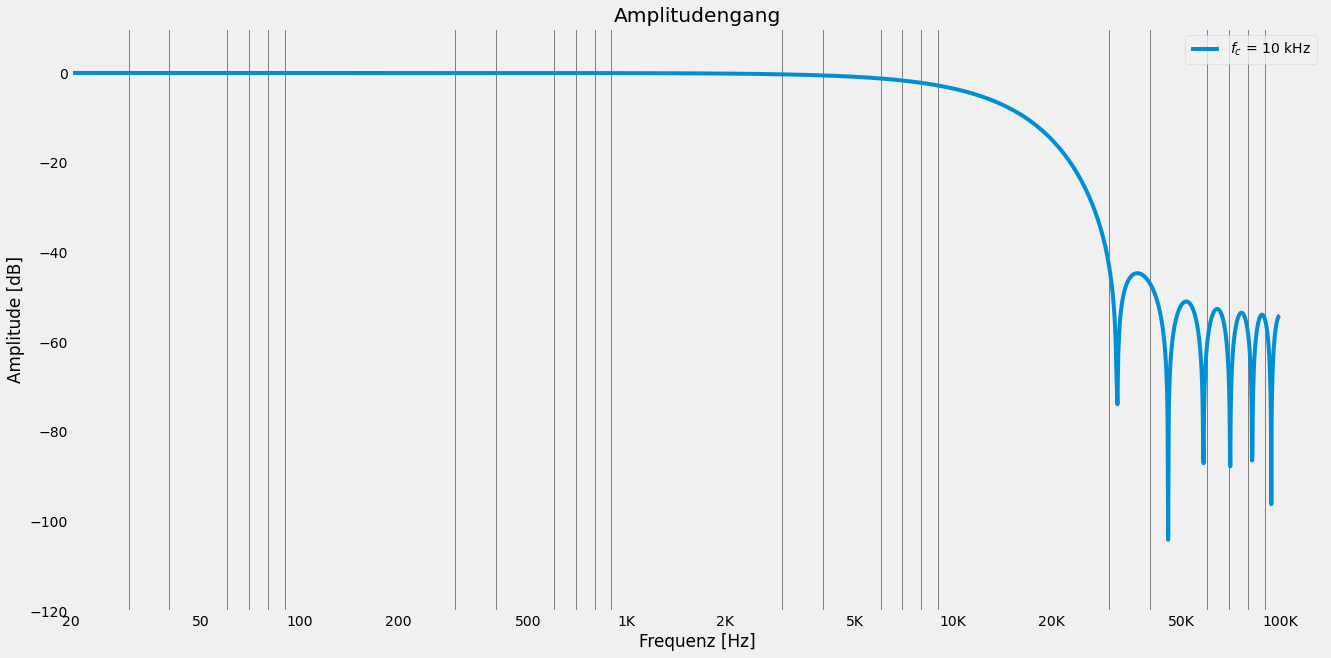

In [6]:
#Amplitudengang

w, h = signal.freqz(b=b)
x = w * fs * 1.0 / (2 * np.pi)
y = 20 * np.log10(abs(h))
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20,10))
plt.semilogx(x, y, label='$f_c$ = 10 kHz')
plt.ylim(-120, 10)
plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequenz [Hz]')
plt.title('Amplitudengang')
plt.legend()
plt.grid(which='both', linestyle='-', color='grey')
plt.xticks([20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000], ["20", "50", "100", "200", "500", "1K", "2K", "5K", "10K", "20K", "50K", "100K"])
plt.show()

In [7]:
#Python Ergebnis
from scipy.io import wavfile
import numpy as np

data = np.int16(np.loadtxt('/Users/dave/Documents/FM-Demodulator/Python/demod_avg.txt'))

#Filter
data_python = np.int16(np.convolve(b,data))

np.savetxt('/Users/dave/Documents/FM-Demodulator/Python/demod_avg_filtered.txt', X = data_python, fmt= '%d')

wavfile.write('/Users/dave/Documents/FM-Demodulator/Python/Signal_Python.wav', 200000, data_python)

In [8]:
#FPGA Ergebnis
from scipy.io import wavfile
import numpy as np

data_fpga = np.int16(np.loadtxt('/Users/dave/Documents/FM-Demodulator/UART/output_data.txt'))

wavfile.write('/Users/dave/Documents/FM-Demodulator/Python/Signal_FPGA.wav', 200000, data_fpga)

In [9]:
#Vergleich der Ausgänge

def count_absolute_ones(arr):
    count = 0
    for value in arr:
        if abs(value) == 1:
            count += 1
    return count

diff = data_fpga - data_python[:len(data_fpga)]
N_wrong = count_absolute_ones(diff)
print('Anzahl falscher Samples', N_wrong)
print('Prozentual:', N_wrong*100/len(diff),'%')
print('Abweichung in Prozent: ', 1*100/data_fpga.max(), '%')

Anzahl falscher Samples 25489
Prozentual: 1.4160602757564746 %
Abweichung in Prozent:  0.020116676725005028 %
